In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

(17621,)
(9710,) (7621,)


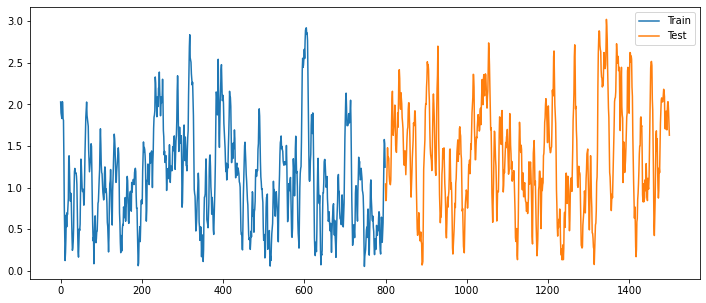

In [2]:
data = {}
entire_data = np.load('amplitude_data.npy')
print(entire_data.shape)
data['train'] = entire_data[:10000]
data['test'] = entire_data[10000:]
idx = np.where(data['train'] > 1e34)[0]
data['train'] = np.delete(data['train'], idx)
print(data['train'].shape, data['test'].shape)

N_train = 800
N_forecast = 700
Ztrain = data['train'][:N_train] 
Ztest = data['train'][N_train:N_train+N_forecast]
# data['train'] = np.load(f'{datadir}/amplitude_data.npy').T
# data['test'] = np.load(f'{datadir}/Z500_Test_Snapshots.npy').T

plt.figure(figsize=(12, 5))
plt.plot(np.arange(N_train), Ztrain)
plt.plot(np.arange(N_train, N_train+N_forecast), Ztest)
plt.legend(['Train', 'Test'])

In [3]:
def rolling(a, window):
    shape = (a.size - window + 1, window)
    strides = (a.itemsize, a.itemsize)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)



In [4]:
rolling_width = 30
Input_X = rolling(Ztrain[:-1], rolling_width)
print(Input_X.shape)
Output_Y = Ztrain[rolling_width:]
print(Output_Y.shape)
x_np = torch.from_numpy(Input_X)
y_np = torch.from_numpy(Output_Y)
#Increase rolling_width 
#Increase number of training points

(770, 30)
(770,)


In [6]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_np, y_np, likelihood)

In [7]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_np)
    # Calc loss and backprop gradients
    loss = -mll(output, y_np)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/100 - Loss: 1.359   lengthscale: 0.693   noise: 0.693
Iter 2/100 - Loss: 1.350   lengthscale: 0.698   noise: 0.688
Iter 3/100 - Loss: 1.341   lengthscale: 0.703   noise: 0.683
Iter 4/100 - Loss: 1.332   lengthscale: 0.708   noise: 0.678
Iter 5/100 - Loss: 1.323   lengthscale: 0.713   noise: 0.673
Iter 6/100 - Loss: 1.314   lengthscale: 0.718   noise: 0.669
Iter 7/100 - Loss: 1.305   lengthscale: 0.724   noise: 0.664
Iter 8/100 - Loss: 1.296   lengthscale: 0.729   noise: 0.659
Iter 9/100 - Loss: 1.288   lengthscale: 0.734   noise: 0.654
Iter 10/100 - Loss: 1.279   lengthscale: 0.739   noise: 0.649
Iter 11/100 - Loss: 1.271   lengthscale: 0.744   noise: 0.644
Iter 12/100 - Loss: 1.262   lengthscale: 0.749   noise: 0.639
Iter 13/100 - Loss: 1.254   lengthscale: 0.755   noise: 0.635
Iter 14/100 - Loss: 1.246   lengthscale: 0.760   noise: 0.630
Iter 15/100 - Loss: 1.238   lengthscale: 0.765   noise: 0.625
Iter 16/100 - Loss: 1.229   lengthscale: 0.770   noise: 0.620
Iter 17/100 - Los

In [8]:
prediction_window  = 30
predictions = np.zeros(prediction_window)
lower_confidence = np.zeros(prediction_window)
upper_confidence = np.zeros(prediction_window)
temp = np.copy(Ztest[:prediction_window+rolling_width-1])
temp = rolling(temp, rolling_width)
model.eval()
likelihood.eval()
for i in range(prediction_window):
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        temp1 = temp[i,:]
        if(i != 0):
            temp1[-1] = observed_pred.mean.numpy()
        test_x = torch.from_numpy(temp1.reshape((1, rolling_width)))
        observed_pred = likelihood(model(test_x))
#         print(observed_pred)
        lower, upper = observed_pred.confidence_region()
        predictions[i] = observed_pred.mean.numpy()
        lower_confidence[i] = lower.detach().numpy()
        upper_confidence[i] = upper.detach().numpy()

(0.0, 4.0)

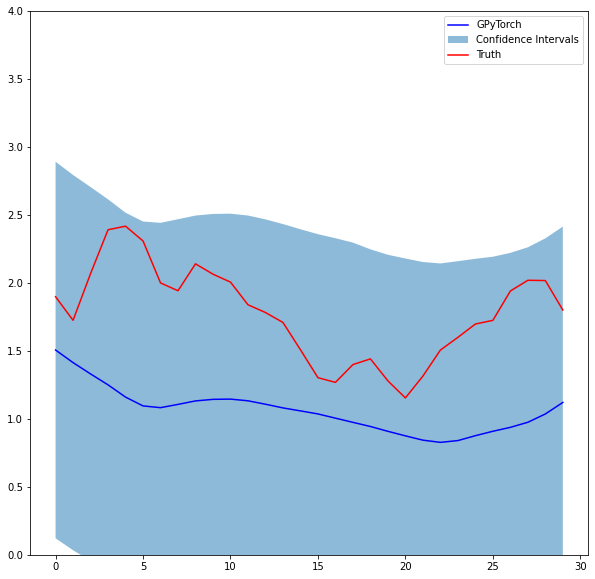

In [9]:
lower, upper = observed_pred.confidence_region()
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(np.arange(prediction_window), predictions, 'b')
# ax.plot(np.arange(200), observed_pred.mean.numpy(), 'b')
ax.fill_between(np.arange(prediction_window), lower_confidence, upper_confidence, alpha=0.5)
ax.plot(np.arange(prediction_window),Ztest[rolling_width:rolling_width+prediction_window], 'r')
ax.legend(['GPyTorch','Confidence Intervals' ,'Truth'])
plt.ylim([0,4])

In [21]:
print(observed_pred.mean.numpy())

[0.83094274 0.95559964 0.94952009 0.97337165 0.32907905 0.45855559
 0.47461445 0.55022795 0.59553601 0.32455301 0.33127434 0.43076506
 0.35122116 0.50287769 0.58995223 0.61903331 0.70199204 0.93217848
 1.13508962 0.90259051 0.99174613 0.7355554  0.65688114 0.67324352
 0.99921632 1.02150639 0.87385877 0.82075519 0.71715092 0.48446677
 0.37147412 0.87061325 1.14444442 1.25829992 1.48237509 1.50171434
 1.45530322 1.56928382 1.35207689 1.43258751 1.36181612 1.38249547
 1.22369445 1.28424335 1.24214669 1.32025189 1.28632129 1.32822991
 1.24705467 1.30341115 1.56794504 1.17698394 0.84185148 0.51520998
 0.67848403 0.83601565 1.12622365 1.04402746 0.95698197 1.1158534
 1.10394328 0.78435842 0.51688241 0.3920233  0.43979093 0.56300027
 1.13259834 1.52308572 1.20366803 0.96645663 0.88610405 1.08509009
 1.60173424 1.71987067 1.32619556 1.09971549 1.2160056  0.90324519
 0.46369284 0.37095038 0.37321177 0.32200714 0.70673543 1.15688953
 1.24702612 1.25255613 1.21143735 1.53425909 1.99405913 2.45413

In [ ]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)